In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import os

import numpy as np

In [2]:
all_images = glob(os.path.join('..', 'data', '*.tif'))
img_df = pd.DataFrame([dict(path = c_file) for c_file in all_images])
img_df['basename'] = img_df['path'].map(lambda x: os.path.basename(x).split('.')[0])
img_df['frame_id'] = img_df['basename'].map(lambda x: '_'.join(x.split('_')[0:-1]))
img_df['sample'] = img_df['basename'].map(lambda x: x.split('_')[0])
img_df['slice'] = img_df['basename'].map(lambda x: int(x.split('_')[3]))
img_df['frame'] = img_df['basename'].map(lambda x: int(x.split('_')[1]))

# group by prefix
img_3d_df = img_df.sort_values(['sample', 'frame_id', 'slice']).groupby(['sample', 'frame', 'frame_id'])['path'].apply(list).reset_index()

img_3d_df

,sample,frame,frame_id,path
0,MI5,0,MI5_0_00,"[../data/MI5_0_00_1500.rec.8bit.tif, ../data/M..."
1,MI5,1,MI5_1_00,"[../data/MI5_1_00_1500.rec.8bit.tif, ../data/M..."
2,MI5,1,MI5_1_01,"[../data/MI5_1_01_1500.rec.8bit.tif, ../data/M..."
3,MI5,1,MI5_1_02,"[../data/MI5_1_02_1500.rec.8bit.tif, ../data/M..."
4,MI7,0,MI7_0_00,"[../data/MI7_0_00_1300.rec.8bit.tif, ../data/M..."
5,MI7,1,MI7_1_00,"[../data/MI7_1_00_1300.rec.8bit.tif, ../data/M..."
6,MI7,1,MI7_1_01,"[../data/MI7_1_01_1300.rec.8bit.tif, ../data/M..."
7,MI7,1,MI7_1_02,"[../data/MI7_1_02_1300.rec.8bit.tif, ../data/M..."


In [3]:
from skimage.io import imread
def paths_to_raw_vol(in_paths):
    return np.stack([imread(x)[400:800:2, 400:800:2] for x in in_paths], 0)
subset_df = img_3d_df.query('sample=="MI7"').copy()
subset_df['volume'] = subset_df['path'].map(paths_to_raw_vol)
subset_df.sample(1)

,sample,frame,frame_id,path,volume
5,MI7,1,MI7_1_00,"[../data/MI7_1_00_1300.rec.8bit.tif, ../data/M...","[[[146, 143, 143, 145, 149, 148, 138, 135, 143..."


In [4]:
subset_df['volume'].map(np.shape)

4    (13, 200, 200)
5    (13, 200, 200)
6    (13, 200, 200)
7    (13, 200, 200)
Name: volume, dtype: object

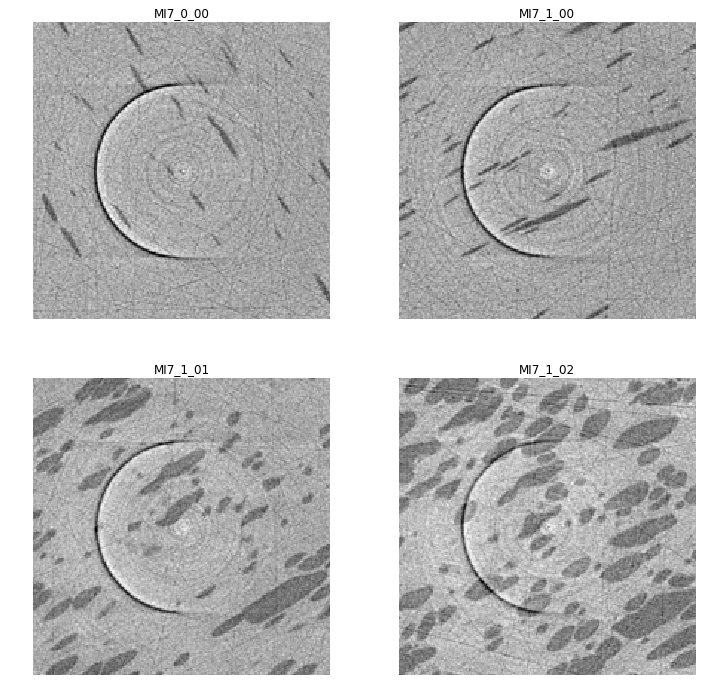

In [5]:
fig, m_axs = plt.subplots(2,2, figsize = (12, 12))
for (_, c_row), c_ax in zip(subset_df.iterrows(), m_axs.flatten()):
    c_ax.imshow(c_row['volume'][c_row['volume'].shape[0]//2], cmap = 'gray')
    c_ax.axis('off')
    c_ax.set_title('{frame_id}'.format(**c_row))

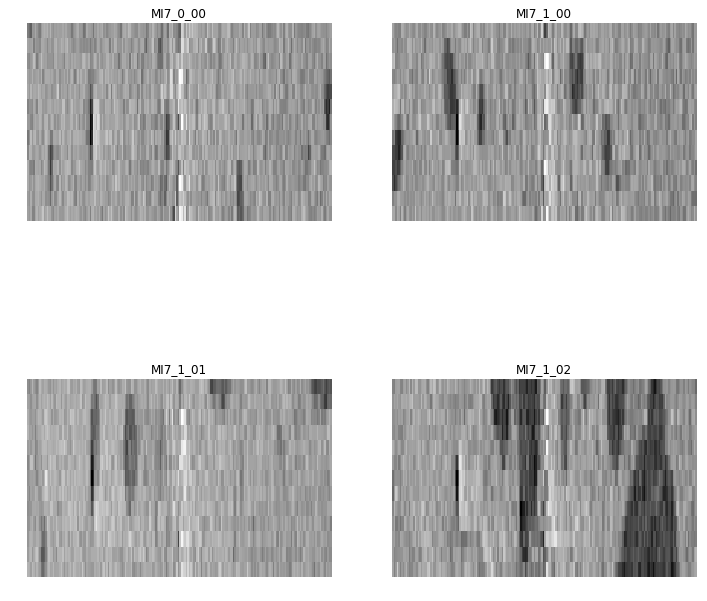

In [6]:
fig, m_axs = plt.subplots(2,2, figsize = (12, 12))
for (_, c_row), c_ax in zip(subset_df.iterrows(), m_axs.flatten()):
    c_ax.imshow(c_row['volume'][:,c_row['volume'].shape[1]//2,:], cmap = 'gray')
    c_ax.axis('off')
    c_ax.set_aspect(10)
    c_ax.set_title('{frame_id}'.format(**c_row))

# 3D Registration with SimpleITK
Here we use a pretty boring registration technique with an affine transform and mean squared error.

In [17]:
import SimpleITK as sitk
def register_img(fixed_arr, 
                 moving_arr,
                use_affine = True,
                use_mse = True,
                brute_force = False):
    fixed_image = sitk.GetImageFromArray(fixed_arr)
    moving_image = sitk.GetImageFromArray(moving_arr)
    transform = sitk.AffineTransform(3) if use_affine else sitk.ScaleTransform(3)
    initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image,moving_image.GetPixelID()), 
                                                      moving_image, 
                                                      transform, 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
    
    ff_img = sitk.Cast(fixed_image, sitk.sitkFloat32)
    mv_img = sitk.Cast(moving_image, sitk.sitkFloat32)
    registration_method = sitk.ImageRegistrationMethod()
    if use_mse:
        registration_method.SetMetricAsMeanSquares()
    else:
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    
    if brute_force:
        sample_per_axis = 12
        registration_method.SetOptimizerAsExhaustive([sample_per_axis//2,0,0])
        # Utilize the scale to set the step size for each dimension
        registration_method.SetOptimizerScales([2.0*3.14/sample_per_axis, 1.0,1.0])
    else:
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetMetricSamplingPercentage(0.25)

    registration_method.SetInterpolator(sitk.sitkLinear)

    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, 
                                                      numberOfIterations=2000, 
                                                      convergenceMinimumValue=1e-7,
                                                      convergenceWindowSize=10)
    # Scale the step size differently for each parameter, this is critical!!!
    registration_method.SetOptimizerScalesFromPhysicalShift() 

    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    final_transform_v1 = registration_method.Execute(ff_img, 
                                                     mv_img)
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    
    if len(final_transform_v1.GetParameters())==12:
        print('Final Params:')
        print(np.array(final_transform_v1.GetParameters()).reshape((4,3)))
    else:
        print('Final Parameters: {}'.format(final_transform_v1.GetParameters()))
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)
    
    # SimpleITK supports several interpolation options, we go with the simplest that gives reasonable results.     
    resample.SetInterpolator(sitk.sitkBSpline)  
    resample.SetTransform(final_transform_v1)
    return sitk.GetArrayFromImage(resample.Execute(moving_image))

In [18]:
subset_df = subset_df.sort_values('frame_id')
ref_img = subset_df.head(1)['volume'].values[0]
fit_df = subset_df.tail(subset_df.shape[0]-1)
fit_df['volume'] = fit_df['volume'].map(lambda x: register_img(ref_img, x))

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 13.
Final metric value: 622.0506281749164
Final Params:
[[ 9.99720389e-01  2.13899684e-04  7.75132263e-03]
 [ 7.01620291e-05  1.00012780e+00  2.30362503e-03]
 [ 6.25534047e-03 -2.68879828e-03  8.97543542e-01]
 [-2.68354834e-02 -3.90438117e-02  7.51814117e-01]]
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 26.
Final metric value: 776.5216414107995
Final Params:
[[ 0.96452469  0.00987656 -0.25661621]
 [ 0.00992934  0.99677446  0.06676145]
 [-0.10389278  0.02648308  0.05104493]
 [-0.12605309  0.00942235 -0.26225702]]
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 329.
Final metric value: 2012.5962808724344
Final Params:
[[ 0.97723616  0.00336987  0.16913851]
 [ 0.02740065  0.96352451  0.17568106]
 [ 0.0528897   0.03974723  0.02883708]
 [-0.82629665  2.06417669  

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


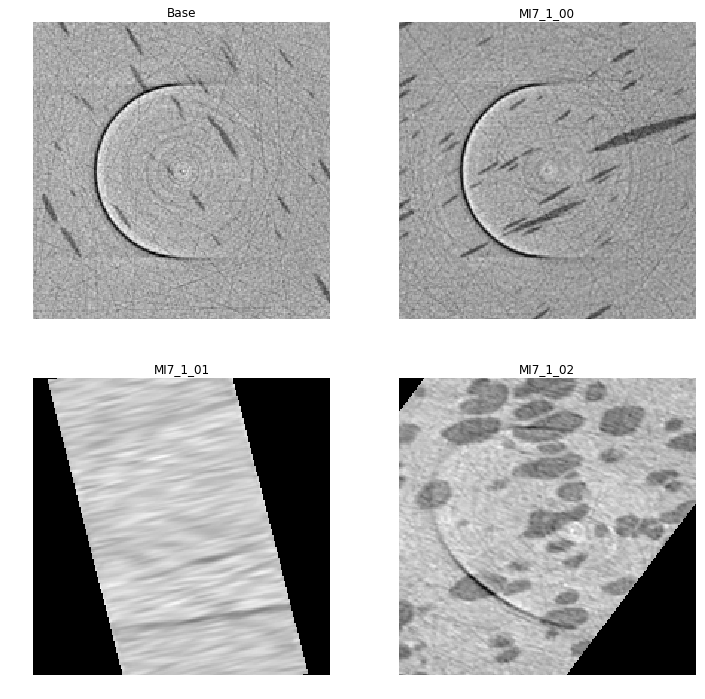

In [19]:
fig, m_axs = plt.subplots(2,2, figsize = (12, 12))
c_ax = m_axs[0,0]
c_ax.imshow(ref_img[ref_img.shape[0]//2], cmap = 'gray')
c_ax.axis('off')
c_ax.set_title('Base')
for (_, c_row), c_ax in zip(fit_df.iterrows(), m_axs.flatten()[1:]):
    c_ax.imshow(c_row['volume'][c_row['volume'].shape[0]//2], cmap = 'gray')
    c_ax.axis('off')
    c_ax.set_title('{frame_id}'.format(**c_row))

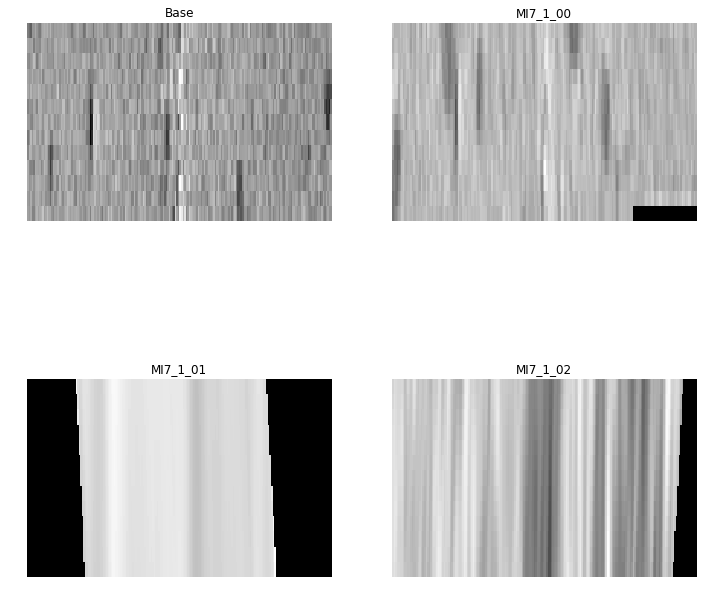

In [20]:
fig, m_axs = plt.subplots(2,2, figsize = (12, 12))
c_ax = m_axs[0,0]
c_ax.imshow(ref_img[:,ref_img.shape[1]//2, :], cmap = 'gray')
c_ax.axis('off')
c_ax.set_aspect(10)
c_ax.set_title('Base')
for (_, c_row), c_ax in zip(fit_df.iterrows(), m_axs.flatten()[1:]):
    c_ax.imshow(c_row['volume'][:,c_row['volume'].shape[1]//2,:], cmap = 'gray')
    c_ax.axis('off')
    c_ax.set_aspect(10)
    c_ax.set_title('{frame_id}'.format(**c_row))

# Show Nice Visualizations
Here I will add some code to show a few nice visualizations to see how well the volumes match

In [ ]:
import ipywidgets as ipw
import ipyvolume as p3